In [1]:
import numpy as np
import json
import os
import gc
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from gensim.parsing import remove_stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dot, Input,Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,TerminateOnNaN,Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects


import tensorflow.keras.backend as K
import pickle

from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## DATASET

In [2]:
docs = [(doc["id"],(doc["title"]+doc["body"])) for doc in json.load(open(os.path.join("..","similarity","crag_doc.json"),"r"))]
queries = [(query["query number"],query["query"]) for query in json.load(open(os.path.join("..","similarity","crag_queries.json"),"r"))][:-1]
relevance = json.load(open(os.path.join("..","similarity","crag_relevance.json"),"r"))

STOP_WORDS = True

if STOP_WORDS:
    docs = { k:word_tokenize(remove_stopwords(v)) for k,v in docs}
    queries = { k:word_tokenize(remove_stopwords(v)) for k,v in queries}
else:
    docs = { k:word_tokenize(v) for k,v in docs}
    queries = { k:word_tokenize(v) for k,v in queries}

query_relevance = defaultdict(list)
[query_relevance[line["query_num"]].append((line["id"],line["position"])) for line in relevance]
query_relevance = [(k,list(map(lambda t:int(t[0]),sorted(v, key=lambda x:-x[1])))) for k,v in query_relevance.items()]
query_relevance = { int(k):v for k,v in query_relevance}



#remove stop words
#docs = { k:remove_stopwords(v) for k,v in docs}
#queries = { k:remove_stopwords(v) for k,v in queries}

print("Num documents",len(docs),"Num queries",len(queries))

def stats_on_text(texts):
    texts_lengths = [len(text) for text in texts]
    print("avg length of the corpus",np.mean(texts_lengths),"std",np.std(texts_lengths))
    print("max length of the corpus",np.max(texts_lengths),"min",np.min(texts_lengths))
    #histogram
    plt.hist(texts_lengths, bins=50)


Num documents 1400 Num queries 225


avg length of the corpus 108.19599427753934 std 53.609195568263864
max length of the corpus 404 min 22


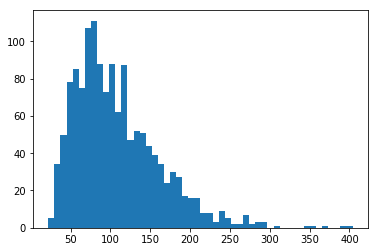

In [3]:

MIN_DOC_WORDS = 10

#remove the document dont cotains any words
empty_docs = { k for k,v in filter(lambda x:len(x[1])<MIN_DOC_WORDS, docs.items()) }

#remove docs
for k in empty_docs:
    del docs[k]

#remove empty docs from groundthruth 
if len(empty_docs)>0:
    for k in query_relevance.keys():
        _temp = set(query_relevance[k])
        if len(_temp&empty_docs)>0:
            query_relevance[k] = list(_temp-empty_docs)
     
#verification
#print(any([len(set(rel)&empty_docs)>0 for k,rel in query_relevance.items()]))

all_doc_ids = set(docs.keys())

stats_on_text(docs.values())

avg length of the corpus 10.95111111111111 std 4.208173117595606
max length of the corpus 26 min 5


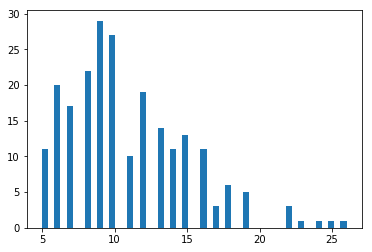

In [4]:
stats_on_text(queries.values())

## LOAD EMBEDDINGS

In [5]:
PATH_EMBEDDINGS = os.path.join("..","similarity","CRAG_OUT_FROM_BIG_FILE_NLTK_TOKENIZER.bin")

model = KeyedVectors.load_word2vec_format(PATH_EMBEDDINGS, binary=True)

print(model.vectors.shape)

(6796, 200)


## Words dont cover by the embeddings

In [6]:
dataset_words = set()

for q in queries.values():
    dataset_words |= set(q)
    
for doc in docs.values():
    dataset_words |= set(doc)
    
valid_vocabulary = list(dataset_words&set(model.index2word))

print("Dataset vocabulary:",len(dataset_words))
print("Embeddings vocabulary:",len(model.index2word))
print("Valid vocabulary:", len(valid_vocabulary))


Dataset vocabulary: 10081
Embeddings vocabulary: 6796
Valid vocabulary: 6658


## Prepare the data

In [7]:
MAX_DOC_LENGTH = 150
MAX_QUERY_LENGTH = 20
#Prepere keras tokenizer

word_index = {token : idx + 1 for idx, token in enumerate(model.index2word)}
word_index["<PAD>"] = 0

reverse_word_index = {idx : token  for token, idx in word_index.items()}

def sequences_to_texts(texts):
    return [' '.join([reverse_word_index.get(i, '?') for i in text]) for text in texts]

keras_tokenizer = Tokenizer(num_words=len(word_index))
keras_tokenizer.fit_on_texts([])# just to create word_index var in the Tokenizer object
keras_tokenizer.word_index = word_index
keras_tokenizer.sequences_to_texts = sequences_to_texts #hacking the Tokenizer object

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(keras_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#TODO tokenize and padding the data
docs_tokenized_padded = {k:(pad_sequences(keras_tokenizer.texts_to_sequences([v]),value=word_index["<PAD>"],padding='pre',maxlen=MAX_DOC_LENGTH)[0]) for k,v in docs.items()}
queries_tokenized_padded = {k:(pad_sequences(keras_tokenizer.texts_to_sequences([v]),value=word_index["<PAD>"],padding='pre',maxlen=MAX_QUERY_LENGTH)[0]) for k,v in queries.items()}

#pad to a fixed length
#docs_tokenized_padded = pad_sequences(docs_tokenized,value=word_index["<PAD>"],padding='pre',maxlen=MAX_LENGTH)
#queries_tokenized_padded = pad_sequences(queries_tokenized,value=word_index["<PAD>"],padding='pre',maxlen=MAX_QUERY_LENGTH)

def sample_training_data(num_query_batch=5, num_pos_docs=5,num_neg_docs=5):
    
    query_index = np.random.randint(len(query_relevance), size=num_query_batch)+1

    X_query_input = []
    X_document_input = []
    Y_similarity = []
    
    for q_i in query_index:
        
        #get relevant documents
        doc_rel = set(query_relevance[q_i])
        doc_rel_select = np.random.choice(list(doc_rel), (num_pos_docs if num_pos_docs<=len(doc_rel) else len(doc_rel))) #usar diferentes prob para mais relevantes?
        
        #negative samples
        doc_neg = all_doc_ids - doc_rel
        doc_neg_select = np.random.choice(list(doc_neg), (num_neg_docs if num_neg_docs<=len(doc_neg) else len(doc_neg)))
        
        #ENSURE THIS!!!
        assert not (doc_rel_select in doc_neg_select)
        
        for e in doc_rel_select:
            X_query_input.append(queries_tokenized_padded[q_i])
            X_document_input.append(docs_tokenized_padded[e])
            Y_similarity.append(1)
        
        for e in doc_neg_select:
            X_query_input.append(queries_tokenized_padded[q_i])
            X_document_input.append(docs_tokenized_padded[e])
            Y_similarity.append(0)
            
    return X_query_input,X_document_input,Y_similarity


#Create data generator

def generator(train_query_index, num_query_batch=5, num_pos_docs=5,num_neg_docs=5):
    
    while True:
        #query_index = np.random.choice(list(train_query_index),num_query_batch)

        #batch slit
        for i in range(0,len(train_query_index),num_query_batch):
        
        
            X_query_input = []
            X_document_input = []
            Y_similarity = []

            for q_i in train_query_index[i:i+num_query_batch]:

                #get relevant documents
                doc_rel = set(query_relevance[q_i])
                doc_rel_select = np.random.choice(list(doc_rel), (num_pos_docs if num_pos_docs<=len(doc_rel) else len(doc_rel))) #usar diferentes prob para mais relevantes?

                #negative samples
                doc_neg = all_doc_ids - doc_rel
                doc_neg_select = np.random.choice(list(doc_neg), (num_neg_docs if num_neg_docs<=len(doc_neg) else len(doc_neg)))

                #ENSURE THIS!!!
                assert not (doc_rel_select in doc_neg_select)

                for e in doc_rel_select:
                    X_query_input.append(queries_tokenized_padded[q_i])
                    X_document_input.append(docs_tokenized_padded[e])
                    Y_similarity.append(1)

                for e in doc_neg_select:
                    X_query_input.append(queries_tokenized_padded[q_i])
                    X_document_input.append(docs_tokenized_padded[e])
                    Y_similarity.append(0)

            yield [np.array(X_document_input),np.array(X_query_input)],np.array(Y_similarity)

def generator_allpos(train_query_index, num_query_batch=5, num_neg_docs=None):
    
    while True:
        #query_index = np.random.choice(list(train_query_index),num_query_batch)

        #batch slit
        for i in range(0,len(train_query_index),num_query_batch):
        
        
            X_query_input = []
            X_document_input = []
            Y_similarity = []

            for q_i in train_query_index[i:i+num_query_batch]:

                #get relevant documents
                doc_rel_select = set(query_relevance[q_i])
                
                #negative samples
                doc_neg = all_doc_ids - doc_rel_select
                if num_neg_docs is not None:
                    doc_neg_select = np.random.choice(list(doc_neg), (num_neg_docs if num_neg_docs<=len(doc_neg) else len(doc_neg)))
                else:
                    doc_neg_select = np.random.choice(list(doc_neg), (len(doc_rel_select) if len(doc_rel_select)<=len(doc_neg) else len(doc_neg)))
                #ENSURE THIS!!!
                assert not (doc_rel_select in doc_neg_select)

                for e in doc_rel_select:
                    X_query_input.append(queries_tokenized_padded[q_i])
                    X_document_input.append(docs_tokenized_padded[e])
                    Y_similarity.append(1)

                for e in doc_neg_select:
                    X_query_input.append(queries_tokenized_padded[q_i])
                    X_document_input.append(docs_tokenized_padded[e])
                    Y_similarity.append(0)

            yield [np.array(X_document_input),np.array(X_query_input)],np.array(Y_similarity)

In [8]:
_d = { k:keras_tokenizer.texts_to_sequences([v])[0] for k,v in docs.items()}
_q = { k:keras_tokenizer.texts_to_sequences([v])[0] for k,v in queries.items()}

avg length of the corpus 87.9005722460658 std 43.553472795168226
max length of the corpus 332 min 19


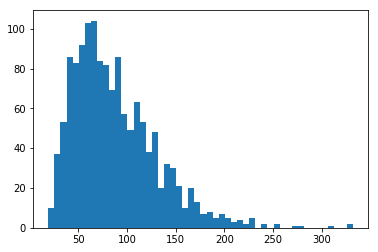

In [9]:
stats_on_text(_d.values())

avg length of the corpus 9.097777777777777 std 3.6623300954986377
max length of the corpus 21 min 2


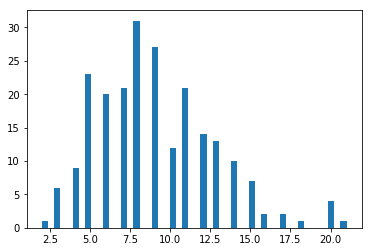

In [10]:
stats_on_text(_q.values())

## Define simple Similarity model with LSTM

In [11]:
#TODO USE the same embedding layer but need different input length
#clear session
K.clear_session()

#TODO USE the same embedding layer but need different input length
delta = 0.0001
embedding_matrix = np.vstack([(np.zeros((1,model.vectors.shape[1]))+delta),model.vectors])

#Document dimentional reduction
doc_model_input = Input(shape=[MAX_DOC_LENGTH], name = "document_model_words_input")
doc_embedding = Embedding( input_dim=embedding_matrix.shape[0],
                           output_dim=embedding_matrix.shape[1], 
                           input_length=MAX_DOC_LENGTH,
                           weights=[embedding_matrix], 
                           trainable=False,
                           name="doc_embedding_layer")(doc_model_input)
doc_lstm1 = LSTM(100,name="doc_lstm_1",activation="selu")(doc_embedding)
doc_dense = Dense(100, activation='tanh', name='doc_dense')(doc_lstm1)

doc_model = Model(inputs=[doc_model_input],outputs=[doc_dense], name="doc_projection_model")
doc_model.summary()

#Query dimentional reduction





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
document_model_words_input ( (None, 150)               0         
_________________________________________________________________
doc_embedding_layer (Embeddi (None, 150, 200)          1359400   
_________________________________________________________________
doc_lstm_1 (LSTM)            (None, 100)               120400    
_________________________________________________________________
doc_dense (Dense)            (None, 100)               10100     
Total params: 1,489,900
Trainable params: 130,500
Non-trainable params: 1,359,400
_________________________________________________________________


In [12]:
query_model_input = Input(shape=[MAX_QUERY_LENGTH], name = "query_model_words_input")
query_embedding = Embedding(input_dim=embedding_matrix.shape[0],
                           output_dim=embedding_matrix.shape[1], 
                           input_length=MAX_QUERY_LENGTH,
                           weights=[embedding_matrix], 
                           trainable=False,
                           name="query_embedding_layer")(query_model_input)
query_lstm1 = LSTM(100,name="query_lstm_1",activation="selu")(query_embedding)
query_dense = Dense(100, activation='tanh', name='query_dense')(query_lstm1)
query_model = Model(inputs=[query_model_input],outputs=[query_dense], name="query_projection_model")
query_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
query_model_words_input (Inp (None, 20)                0         
_________________________________________________________________
query_embedding_layer (Embed (None, 20, 200)           1359400   
_________________________________________________________________
query_lstm_1 (LSTM)          (None, 100)               120400    
_________________________________________________________________
query_dense (Dense)          (None, 100)               10100     
Total params: 1,489,900
Trainable params: 130,500
Non-trainable params: 1,359,400
_________________________________________________________________


In [13]:


def custom_activation(x):
    return K.sigmoid(x*10-3)

#get_custom_objects().update({'custom_activation': Activation(custom_activation)})

doc_input = Input(shape=[MAX_DOC_LENGTH], name = "document_words_input")
query_input = Input(shape=[MAX_QUERY_LENGTH], name = "query_words_input")
doc_model_output = doc_model(doc_input)
query_model_output = query_model(query_input)
similarity = Dot(axes=1,normalize=True)([doc_model_output,query_model_output])
sig_activation = Activation("sigmoid")(similarity)
#sig_activation = Activation(custom_activation)(similarity)
#sig_sim = Dense(1,activation='sigmoid',name="sigmoid_convert")(similarity)

similarity_model = Model(inputs=[doc_input,query_input],outputs=[sig_activation], name="doc_query_sim")

similarity_model.summary()

similarity_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
LOAD = False
if LOAD:
    similarity_model = load_model("best_similarity_model_generator_allpos_400_no_dropout_adam")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_words_input (InputLaye (None, 150)          0                                            
__________________________________________________________________________________________________
query_words_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
doc_projection_model (Model)    (None, 100)          1489900     document_words_input[0][0]       
__________________________________________________________________________________________________
query_projection_model (Model)  (None, 100)          1489900     query_words_input[0][0]          
__________________________________________________________________________________________________
dot (Dot) 

## Prepare training 

In [14]:

#select 25 questions from query_relevance, TRAIN TEST SPLIT
def select_split_data(test_percentage):
    
    test_size = int(len(query_relevance)*test_percentage)
    print("Num test samples:",test_size)
    
    query_id= set(query_relevance.keys()) 
    query_test_id = set(np.random.choice(list(query_relevance.keys()),size=test_size))
    query_train_id = query_id-query_test_id
    
    #stupid verification because np.random.chois IS STUPID but i dont have time to do it properly
    if (len(query_train_id)+len(query_test_id)) != len(query_id): #try until random do a good job
        print("try again")
        return select_split_data(test_size)
    
    return list(query_train_id),list(query_test_id)


NUM_TEST_PERCENTAGE = .2
BATCH_SIZE = 5
query_train_id, query_test_id = select_split_data(NUM_TEST_PERCENTAGE)

class ComputeTestSet(Callback):
    
    def on_epoch_end(self,epoch, logs={}):
        
        loss,acc = self.model.evaluate_generator(generator=generator_allpos(query_test_id, BATCH_SIZE),
                                   steps=len(query_train_id)//BATCH_SIZE)

        logs["test_loss"] = loss
        logs["test_acc"] = acc
        
        print(" - test_loss: {0:.4f} - test_acc: {1:.4f}".format(loss,acc))

Num test samples: 45


In [17]:
print(query_test_id)

[128, 1, 130, 3, 7, 11, 140, 12, 142, 143, 144, 145, 21, 27, 156, 29, 163, 38, 41, 42, 171, 172, 178, 59, 68, 69, 74, 203, 202, 79, 83, 215, 218, 223, 100, 102, 107, 113, 114, 117]


## Training

In [16]:
#callbacks

tensorboard = TensorBoard(log_dir=os.path.join("../tensorboard/dssm_generator_allpos_no_dropout"), histogram_freq=0,write_graph=True, write_images=False)
check=ModelCheckpoint("best_similarity_model_generator_allpos_400_no_dropout_adam", monitor='loss', save_best_only=True, verbose=1, save_weights_only=False, mode='min')

callbacks = [ComputeTestSet(),check,tensorboard,TerminateOnNaN()]

similarity_model.fit_generator(generator=generator_allpos(query_train_id, BATCH_SIZE), 
                               epochs=200,
                               callbacks=callbacks,
                               steps_per_epoch=len(query_train_id)//BATCH_SIZE)

#query_model.save("query_model_no_dropout.hdf5")
#doc_model.save("doc_model_no_dropout.hdf5")
similarity_model.save("similarity_model_generator_allpos_400_no_dropout.hdf5")
#JUMP THIS CODE!!! IS ONLY FOR COMPARATION WITH FIT_GENERATOR
if False:
    epoach = 500
    for _ in range(epoach):
        start_t = time.time()
        X_query,X_document,Y_similarity = sample_training_data(20, num_pos_docs=1, num_neg_docs=1)
        end_sample = time.time()
        similarity_model.train_on_batch([X_document,X_query],Y_similarity)
        end_train = time.time()

        print("Last epoach: {0:d} sample time: {1:.2f} train time: {2:.2f}".format(_,end_sample-start_t,end_train-end_sample))

Epoch 1/200
36/37 [============================>.] - ETA: 0s - loss: 0.5059 - acc: 0.8196 - test_loss: 0.6432 - test_acc: 0.6449

Epoch 00001: loss improved from inf to 0.51334, saving model to best_similarity_model_generator_allpos_400_no_dropout_adam
37/37 [==============================] - 34s 918ms/step - loss: 0.5072 - acc: 0.8187
Epoch 2/200
36/37 [============================>.] - ETA: 0s - loss: 0.5134 - acc: 0.8158 - test_loss: 0.6441 - test_acc: 0.6449

Epoch 00002: loss did not improve from 0.51334
37/37 [==============================] - 33s 904ms/step - loss: 0.5144 - acc: 0.8157
Epoch 3/200
36/37 [============================>.] - ETA: 0s - loss: 0.5042 - acc: 0.8249 - test_loss: 0.6482 - test_acc: 0.6404

Epoch 00003: loss improved from 0.51334 to 0.51206, saving model to best_similarity_model_generator_allpos_400_no_dropout_adam
37/37 [==============================] - 34s 911ms/step - loss: 0.5063 - acc: 0.8228
Epoch 4/200
36/37 [============================>.] - ETA: 

Epoch 31/200
36/37 [============================>.] - ETA: 0s - loss: 0.5059 - acc: 0.8222 - test_loss: 0.6414 - test_acc: 0.6389

Epoch 00031: loss did not improve from 0.51087
37/37 [==============================] - 34s 921ms/step - loss: 0.5081 - acc: 0.8198
Epoch 32/200
36/37 [============================>.] - ETA: 0s - loss: 0.5084 - acc: 0.8225 - test_loss: 0.6549 - test_acc: 0.6222

Epoch 00032: loss did not improve from 0.51087
37/37 [==============================] - 36s 972ms/step - loss: 0.5098 - acc: 0.8210
Epoch 33/200
36/37 [============================>.] - ETA: 0s - loss: 0.5045 - acc: 0.8281 - test_loss: 0.6412 - test_acc: 0.6478

Epoch 00033: loss improved from 0.51087 to 0.50990, saving model to best_similarity_model_generator_allpos_400_no_dropout_adam
37/37 [==============================] - 33s 903ms/step - loss: 0.5061 - acc: 0.8266
Epoch 34/200
36/37 [============================>.] - ETA: 0s - loss: 0.5055 - acc: 0.8267 - test_loss: 0.6443 - test_acc: 0.6542



36/37 [============================>.] - ETA: 0s - loss: 0.5052 - acc: 0.8315 - test_loss: 0.6575 - test_acc: 0.6140

Epoch 00061: loss did not improve from 0.50523
37/37 [==============================] - 9s 230ms/step - loss: 0.5071 - acc: 0.8300
Epoch 62/200
36/37 [============================>.] - ETA: 0s - loss: 0.5156 - acc: 0.8123 - test_loss: 0.6618 - test_acc: 0.6096

Epoch 00062: loss did not improve from 0.50523
37/37 [==============================] - 22s 586ms/step - loss: 0.5175 - acc: 0.8103
Epoch 63/200
36/37 [============================>.] - ETA: 0s - loss: 0.5053 - acc: 0.8351 - test_loss: 0.6567 - test_acc: 0.6155

Epoch 00063: loss did not improve from 0.50523
37/37 [==============================] - 9s 234ms/step - loss: 0.5070 - acc: 0.8339
Epoch 64/200
36/37 [============================>.] - ETA: 0s - loss: 0.5051 - acc: 0.8252 - test_loss: 0.6533 - test_acc: 0.6274

Epoch 00064: loss did not improve from 0.50523
37/37 [==============================] - 9s 230m

KeyboardInterrupt: 

In [35]:
X_query,X_document,Y_similarity = sample_training_data(100, num_pos_docs=5,num_neg_docs=5)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [58]:
similarity_model.evaluate_generator(generator=generator(query_test_id, BATCH_SIZE, num_pos_docs=5, num_neg_docs=5),
                                   steps=len(query_train_id)//BATCH_SIZE)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:86: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


[0.698618407281877, 0.6664280608115063]

[2, 132, 134, 7, 10, 140, 142, 15, 144, 149, 23, 152, 153, 26, 25, 30, 31, 160, 163, 40, 170, 42, 172, 178, 51, 56, 185, 57, 59, 186, 190, 194, 197, 205, 209, 83, 211, 86, 221, 93, 223, 224, 97, 99, 101, 103, 106, 109, 110, 115, 118, 121, 127]
